## Ejercicio 1: Construcción de una Red Neuronal LSTM con Keras"

## Dataset utilizado: Microsoft (MSFT) - 2006 a 2017

Este conjunto de datos contiene los precios bursátiles diarios de la empresa Microsoft (ticker: MSFT) desde el 1 de enero de 2006 hasta el 31 de diciembre de 2017. Los datos forman parte del conjunto más amplio que incluye 29 de las 30 empresas del índice Dow Jones de India, del cual hemos extraído únicamente la serie correspondiente a Microsoft para facilitar el análisis.

El precio del Dow Jones indica si los precios de las acciones de las empresas del índice están subiendo o bajando. Si el precio del Dow Jones está aumentando, significa que una empresa o grupo de empresas específico está experimentando ganancias, lo que se refleja en el precio del índice general.

### Estructura del Dataset

El archivo CSV incluye las siguientes columnas:

- Date: Fecha de la cotización (formato yy-mm-dd).
- Open: Precio de apertura del mercado.
- High: Precio máximo alcanzado ese día.
- Low: Precio mínimo alcanzado ese día.
- Close: Precio de cierre del mercado.
- Volume: Número de acciones negociadas.
- Name: Ticker de la empresa (en este caso, "MSFT").

### ¿Por qué este dataset?

Este dataset cumple perfectamente con los requisitos del ejercicio:

- Es una serie temporal real, con una frecuencia diaria y datos continuos.
- Se enfoca en un tema relevante como los mercados bursátiles.
- Tiene un volumen manejable, ideal para el desarrollo y entrenamiento de modelos LSTM en un entorno con poca capacidad de procesamiento.

### Fuente del dataset

Este conjunto de datos ha sido descargado desde Kaggle y forma parte del siguiente repositorio público:  
https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs



In [ ]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Carga del dataset
ruta = 'MSFT_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(ruta)

# Visualización
print("Primeras filas del dataset:")
print(df.head())

print("\nResumen de columnas:")
print(df.info())

Primeras filas del dataset:
         Date   Open   High    Low  Close     Volume  Name
0  2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT
1  2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT
2  2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT
3  2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT
4  2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT

Resumen de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB
None



Se ha importado las librerías necesarias (`pandas`, `numpy`, `matplotlib`) y cargado el archivo `MSFT_2006-01-01_to_2018-01-01.csv`.

El dataset incluye 3019 registros y no contiene valores nulos. Las columnas disponibles son:

- Date: Fecha de cotización
- Open, High, Low, Close: Valores bursátiles diarios
- Volume: Volumen de acciones negociadas
- Name: Ticker (en este caso, "MSFT")





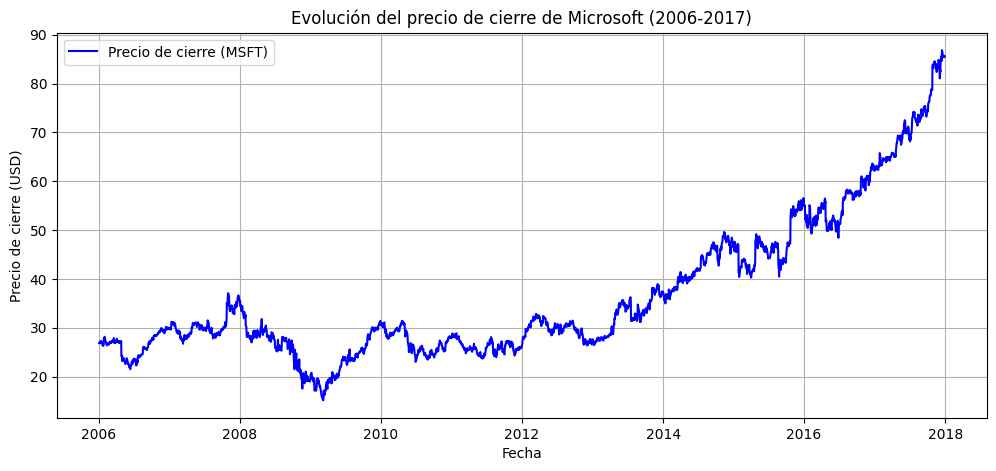

In [ ]:
# columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha por si acaso
df = df.sort_values('Date')

# Resetear índice
df.reset_index(drop=True, inplace=True)

# Visualizar evolución del precio de cierre (columna close)
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Precio de cierre (MSFT)', color='blue')
plt.title('Evolución del precio de cierre de Microsoft (2006-2017)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (USD)')
plt.grid(True)
plt.legend()
plt.show()


En este paso se ha convertido la columna `Date` al tipo `datetime`, se ha ordenado cronológicamente el dataset y se ha generado una visualización de la evolución del precio de cierre de la acción de Microsoft (`Close`) entre los años 2006 y 2017.

La gráfica muestra un crecimiento progresivo, especialmente a partir de 2013, lo cual será útil para que la red LSTM aprenda los patrones de comportamiento temporal en los datos.

Esta visualización también confirma que los datos están completos y en buen estado, sin vacíos ni saltos bruscos que indiquen errores o registros perdidos.


In [ ]:
# Extraer columna 'Close' como serie de trabajo
close_prices = df[['Close']].values  # convertimos a array 2D

# Escalado
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

# División en entrenamiento y test [80%  y 20% ]
train_size = int(len(scaled_close) * 0.8)
test_size = len(scaled_close) - train_size

train_data = scaled_close[:train_size]
test_data = scaled_close[train_size:]

# Comprobación
print(f"Tamaño total: {len(scaled_close)}")
print(f"Entrenamiento: {len(train_data)}")
print(f"Test: {len(test_data)}")
print("Primeras 5 filas de datos escalados:")
print(scaled_close[:5])


Tamaño total: 3019
Entrenamiento: 2415
Test: 604
Primeras 5 filas de datos escalados:
[[0.16304045]
 [0.16485356]
 [0.1651325 ]
 [0.16401674]
 [0.16331939]]


En este paso se ha extraído la columna `Close` como variable objetivo para la predicción y se ha escalado utilizando la técnica `MinMaxScaler`, normalizando los valores en el rango [0, 1].

Este escalado es esencial en modelos LSTM y en cualquier modelo en general.

Posteriormente, se ha dividido el conjunto de datos en dos subconjuntos:

- Entrenamiento: 2415 observaciones (80%)
- Test: 604 observaciones (20%)

Esta división permite entrenar el modelo con una parte del histórico y evaluar su rendimiento sobre datos no vistos.


In [ ]:
# Función para crear secuencias
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i - timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#  longitud de la secuencia
timesteps = 50

# Generamos las secuencias para entrenamiento y test
X_train, y_train = create_sequences(train_data, timesteps)
X_test, y_test = create_sequences(test_data, timesteps)

# Reshape para LSTM: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# formas
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (2365, 50, 1)
y_train shape: (2365,)
X_test shape: (554, 50, 1)
y_test shape: (554,)


Las redes LSTM requieren como entrada una secuencia de datos en lugar de valores individuales. En este paso hemos transformado la serie temporal de precios de cierre en secuencias supervisadas.

Para ello, hemos definido una ventana de 50 días (`timesteps = 50`). Cada entrada (`X`) contiene los precios de los 50 días anteriores, y su salida correspondiente (`y`) es el precio del día siguiente.

Obteniendo:

- 2365 secuencias para entrenamiento
- 554 secuencias para test


 `[muestras, pasos de tiempo, características]`-> `(n, 50, 1)`


In [ ]:
# Definición del modelo
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

# Compilación
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

El modelo incluye:

- Una capa `LSTM` con 50 unidades, que procesa secuencias de 50 pasos temporales con 1 característica cada uno.
- Una capa `Dense` con una única unidad de salida, que genera la predicción del valor siguiente de la serie temporal.

El modelo se ha compilado utilizando el optimizador `adam` y la función de pérdida `mean_squared_error`.

El resumen del modelo muestra:

- 10,400 parámetros entrenables en la capa LSTM.
- 51 parámetros en la capa densa de salida.



In [ ]:
# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0056 - val_loss: 6.8798e-04
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.7469e-04 - val_loss: 4.0501e-04
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.4268e-04 - val_loss: 4.1674e-04
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.3517e-04 - val_loss: 5.0939e-04
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.4185e-04 - val_loss: 4.2662e-04
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.2808e-04 - val_loss: 5.5551e-04
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.1774e-04 - val_loss: 4.9004e-04
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.1352e-04 - val_loss: 3.5720e-04
Epoch 9/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.1069e-04 - val_loss: 3.4804e-04
Epoch 10/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.1835e-04 - val_loss: 3.1822e-04
Epoch 11/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.2221e-04 - 

El modelo LSTM ha sido entrenado durante 30 épocas utilizando un tamaño de batch de 32 y un 10% de los datos de entrenamiento como conjunto de validación interna.

Durante el entrenamiento, se observó una reducción progresiva tanto en la pérdida del conjunto de entrenamiento (`loss`) como en la pérdida del conjunto de validación (`val_loss`), lo cual indica que el modelo ha sido capaz de aprender los patrones del histórico de precios de cierre sin sobreajustar.

- Pérdida inicial (época 1): `loss ≈ 0.0056`, `val_loss ≈ 0.00069`
- Pérdida final (época 30): `loss ≈ 0.000079`, `val_loss ≈ 0.000181`

Esto sugiere que el modelo está bien ajustado.

 A continuación lo visualizaremos para que sea más interpretable.


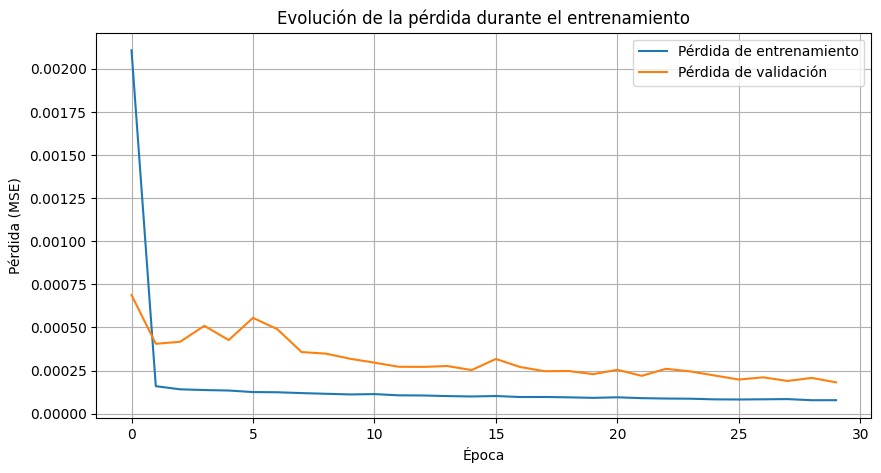

In [ ]:
# Visualizar evolución de la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


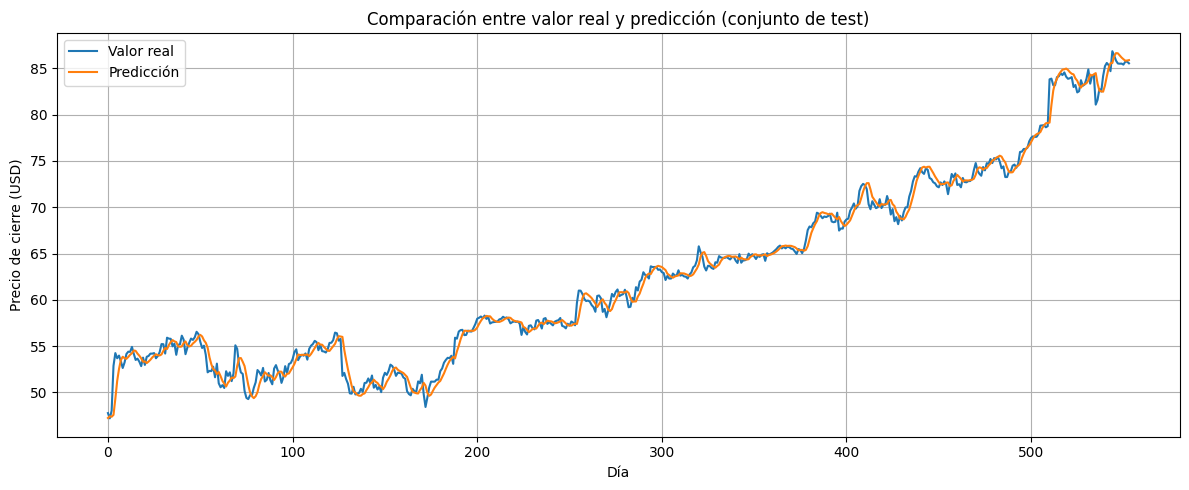

In [ ]:
# predicciones
predicted_scaled = model.predict(X_test)

# Invertir la escala para llevar los datos a sus valores originales
predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
# Visualización
plt.figure(figsize=(12, 5))
plt.plot(y_test_real, label='Valor real')
plt.plot(predicted, label='Predicción')
plt.title('Comparación entre valor real y predicción (conjunto de test)')
plt.xlabel('Día')
plt.ylabel('Precio de cierre (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


En esta fase se ha realizado la predicción del precio de cierre de Microsoft sobre el conjunto de test utilizando el modelo LSTM previamente entrenado.

Dado que los datos se habían escalado con `MinMaxScaler`, tanto las predicciones como los valores reales han sido transformados de nuevo a sus valores originales para poder interpretarlos permitiendo ser graficados de manera comparativa.

En la gráfica se observa que las predicciones del modelo (línea naranja) siguen muy de cerca el comportamiento real del mercado (línea azul), lo que indica que el modelo ha sido capaz de aprender y generalizar los patrones de la serie temporal de forma efectiva.

Esto valida el rendimiento del modelo y su capacidad para realizar predicciones..
